<a href="https://colab.research.google.com/github/krittintrs/DL-for-PM2.5-Prediction/blob/main/DL_PM25_hyperparameter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Change directory to my Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os

cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
os.chdir('/content/gdrive/My Drive/')
cwd = os.getcwd()
print("Files in %r: %s" % (cwd, files))

Files in '/content/gdrive/My Drive': ['.config', 'gdrive', 'sample_data']


# Hyperparameter Adjustment

## Data Preparation

### Import libraries & files

In [3]:
from keras import regularizers
from keras.callbacks import EarlyStopping ,ModelCheckpoint
from keras.models import Sequential
from math import sqrt
from scipy.interpolate import interpn
import joblib
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import Dense

dir = './ESC/DL for Air Quality Prediction/'
file_name = 'project(noday).csv'
hint = file_name[:-4]
df = pd.read_csv(dir+file_name, na_values=['-', ' '])
df = df.drop(df.columns[df.columns.str.contains('Bangna',case = False)],axis = 1) 

# filtering the missing values based on features of experiment
df_=df[(df['pm2.5'] >= 0) & (df['pm2.5_lag1']>= 0) & (df['pm2.5_lag2']>= 0)].reset_index(drop=True)

# X=input features and Y=target selection  
y=df_[['pm2.5']]

LIST=['rainfall',
      'rainfall_lag1',
      'rainfall_lag2',
      'RH',
      'wind_speed',
      'temp',
      'pm2.5_lag1',
      'pm2.5_lag2',
      #'dayofyear',
      #'weekday',
      'visibility'
      ]

x=df_[LIST]


### Normalization & Train-Test Split

In [14]:
# Normalization
scaler_list=['standard'] #'minmax','robust',
for scaler in scaler_list:
    if scaler== 'standard':
        scalerx = StandardScaler().fit(x)
        scalery = StandardScaler().fit(y)
    elif scaler == 'robust':
        scalerx = RobustScaler().fit(x)
        scalery = RobustScaler().fit(y)
    elif scaler == 'minmax':
        scalerx = MinMaxScaler(feature_range=(-1, 1)).fit(x)
        scalery = MinMaxScaler(feature_range=(-1, 1)).fit(y)
# Scale the train set
    x1 = scalerx.transform(x)
    y1 = scalery.transform(y)
    dataset_size=len(x1)
    x_train, x_test, y_train, y_test = train_test_split(x1, y1, test_size=0.30, random_state=3)
# save scaler
    scaler_filename = dir+'/scaler/'+scaler+'/'+hint+'/XHscaler.save'
    joblib.dump(scalerx, scaler_filename) 
    scaler_filename = dir+'/scaler/'+scaler+'/'+hint+'/YHscaler.save'
    joblib.dump(scalery, scaler_filename) 

## Comparing Hyperparameters

Start from one layer and one node. <br />
Then, increasing node until the result is worse. <br />
After that, try increasing the layer. <br />
Repeat this until found the architecture that give the best result.

In [15]:
hyper1 = [6,6]
hyper2 = [6,6,6]
num_epochs = 100

### Define 4-fold validation

In [38]:
# define and fit model
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras import Sequential      
        
def train(x_train,y_train,x_test,y_test,getmodel,num_epochs):
    model=getmodel
    opt='adam'
    model.compile(loss='mean_absolute_error',optimizer=opt,metrics=['mae'])
        
    # K-fold validation 

    k = 4
    num_val_samples = len(x_train) // k
    all_mae_histories = []

    for i in range(k):
        print('processing fold #', i)
        val_data = x_train[i * num_val_samples: (i + 1) * num_val_samples]
        val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]
    
        partial_x_train = np.concatenate(
            [x_train[:i * num_val_samples],
            x_train[(i + 1) * num_val_samples:]],
            axis=0)
    
        partial_y_train = np.concatenate(
            [y_train[:i * num_val_samples],
            y_train[(i + 1) * num_val_samples:]],
            axis=0)

        history = model.fit(partial_x_train, 
                            partial_y_train,
                            validation_data=(val_data, val_targets),
                            epochs=num_epochs, 
                            verbose=0)

        mae_history = history.history['loss']
        all_mae_histories.append(mae_history) 
    
    return history ,model ,all_mae_histories

### Train 1st Model

In [39]:
import datetime
start_time = datetime.datetime.now()

textnum1 = ''
for num in hyper1: 
    textnum1 += str(num) + ' '
    
smodel = Sequential()
smodel.add(Dense(hyper1[0], input_dim=x_train.shape[1], activation='relu'))
smodel.add(Dense(hyper1[1], activation='relu',kernel_regularizer=regularizers.l2(0.002)))
#smodel.add(Dense(hyper1[2], activation='relu',kernel_regularizer=regularizers.l2(0.002)))
#smodel.add(Dense(hyper1[3], activation='relu',kernel_regularizer=regularizers.l2(0.002)))
#smodel.add(Dense(20, 
#                kernel_regularizer=regularizers.l2(0.001),
#                activity_regularizer=regularizers.l1(0.001),activation='relu'))
# activity_regularizer can also be used.
smodel.add(Dense(1))
          
history1,model1,all_mae_his1 = train(x_train,y_train,x_test,y_test,smodel,num_epochs)
end_time = datetime.datetime.now()

print ('Select Done..., Time Cost: %d' % ((end_time - start_time).seconds)) 

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
Select Done..., Time Cost: 9


### Train 2nd Model

In [40]:
import datetime
start_time = datetime.datetime.now()

textnum2 =''

for num in hyper2: 
    textnum2 += str(num) + ' '

bmodel = Sequential()
bmodel.add(Dense(hyper2[0], input_dim=x_train.shape[1], activation='relu'))
bmodel.add(Dense(hyper2[1], activation='relu',kernel_regularizer=regularizers.l2(0.002)))
bmodel.add(Dense(hyper2[2], activation='relu',kernel_regularizer=regularizers.l2(0.002)))
#bmodel.add(Dense(hyper2[3], activation='relu',kernel_regularizer=regularizers.l2(0.002)))
#bmodel.add(Dense(20, 
#                kernel_regularizer=regularizers.l2(0.001),
#                activity_regularizer=regularizers.l1(0.001),activation='relu'))
# activity_regularizer can also be used.
bmodel.add(Dense(1))

history2,model2,all_mae_his2 = train(x_train,y_train,x_test,y_test,bmodel,num_epochs)
end_time = datetime.datetime.now()

print ('Select Done..., Time Cost: %d' % ((end_time - start_time).seconds))     

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
Select Done..., Time Cost: 10


### Model Summary

In [41]:
ave_mae_his1 = [np.mean([x[i] for x in all_mae_his1]) for i in range(num_epochs)]
ave_mae_his2 = [np.mean([x[i] for x in all_mae_his2]) for i in range(num_epochs)]

In [42]:
print(model1.summary())
print(model2.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 6)                 60        
_________________________________________________________________
dense_33 (Dense)             (None, 6)                 42        
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 7         
Total params: 109
Trainable params: 109
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 6)                 60        
_________________________________________________________________
dense_36 (Dense)             (None, 6)                 42        
___________________________

## Plotting Result for Comparison

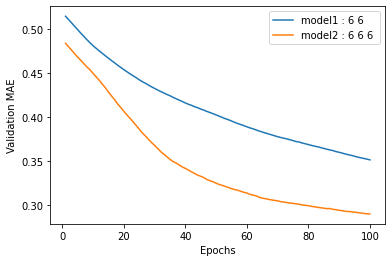

In [43]:
import matplotlib.pyplot as plt

fig1 = plt.gcf()
plt.plot(range(1, len(ave_mae_his1) + 1), ave_mae_his1,label='model1 : '+textnum1)
plt.plot(range(1, len(ave_mae_his2) + 1), ave_mae_his2,label='model2 : '+textnum2)
#plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.legend(loc='upper right')                                      
plt.show()

From the graph, we can see that model2 (6x3) has a better result than model1 (6x2). Then, we should try comparing between 6x3 and 7x3.